# One-dimensional bandwidth sweep

In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import dict_concatenate, dict_mean
from tqdm import tqdm
import time

# from svgd import SVGD
import svgd
import metrics
import utils
import plot

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
dist = metrics.Gaussian(0, 6)
dist.ksd_grid = (0.01, 0.1, 1, 40, 100)
dist.initialize_metric_names()
n = 100
d = dist.d
# svgd_main = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

grid_length = 40
bandwidth_grid = np.linspace(0.5, 60, num=grid_length)
# bandwidth_grid = np.logspace(-1, 3, num=grid_length, base=10)

lr = 0.01
svgd_stepsize = 1

  0%|          | 1/200 [00:00<00:39,  5.02it/s]

JIT COMPILING step...
...done compiling step after 0.39569664001464844 seconds.


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


took 5.911587238311768 seconds
[7.0993166 7.1706657 7.242732  7.3155227]


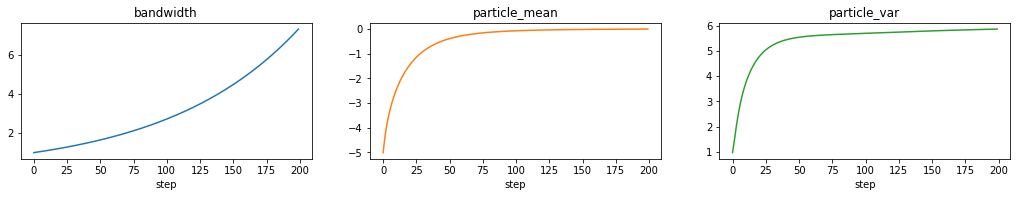

In [11]:
"""run SVGD.train() for L0 steps"""
L0 = 200
svgd0 = svgd.SVGD(dist, L0, particle_shape=(n, d), adagrad=False)
h0 = 1
ksd_bandwidth = 40
lr = 0.01
svgd_stepsize = 1
rkey = random.split(rkey)[0]

st = time.time()
x, log, losses = svgd0.train(rkey, h0, lr, svgd_stepsize, L0, ksd_bandwidth, update_after=0)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print(log["desc"]["bandwidth"][-4:][:, 0])

current_h = log["desc"]["bandwidth"][-4:][-1, 0]

plot.svgd_log(log)

## sweep

In [12]:
def get_metrics(rkey, h):
    """get metrics (incl loss) from SVGD.step"""
    xout = svgd.update(x, dist.logpdf, svgd_stepsize, h, None, False, None)
    return dist.compute_metrics(xout)

In [13]:
def sweep(rkey, grid):
    """Sweep a grid of bandwidth values and output corresponding metrics."""
    sweep_results = []
    for h in grid:
        metrics = get_metrics(rkey, h)
        sweep_results.append(metrics)
    return {k: np.stack([metrics[k] for metrics in sweep_results], axis=0) for k in dist.metric_names.keys()}
# entries in dict have shapes (k, 3, d) and (k, 3)

In [14]:
m = 1
metrics_sweep = []
sweeps = []
for i in tqdm(range(m)):
#     print(f"Sweep {i+1} of {m}")
    rkey = random.split(rkey)[0]
    s = sweep(rkey, bandwidth_grid)
    sweeps.append(s)

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


In [15]:
sweeps = dict_mean(sweeps)

current bandwidth: 7.3155227


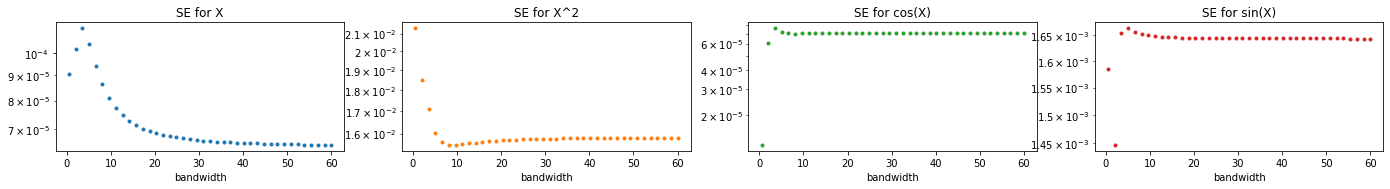

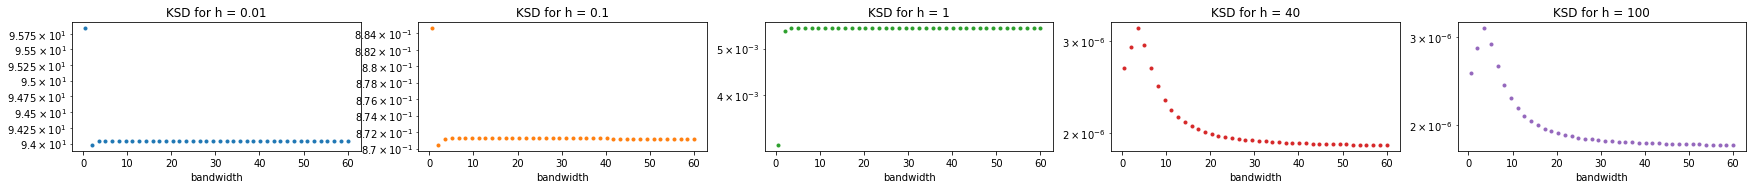

In [22]:
print("current bandwidth:", current_h)
for k, v in sweeps.items():
    plot.plotobject(np.rollaxis(v, axis=1), xaxis=bandwidth_grid, titles=dist.metric_names[k], 
                    xscale="linear", yscale="log", xlabel="bandwidth", style=".")

(array([ 3.,  1., 10.,  9., 18., 20., 16., 11.,  5.,  7.]),
 array([-6.215726  , -5.0916357 , -3.967546  , -2.8434558 , -1.7193658 ,
        -0.5952759 ,  0.52881414,  1.6529042 ,  2.7769942 ,  3.9010842 ,
         5.025174  ], dtype=float32),
 <a list of 10 Patch objects>)

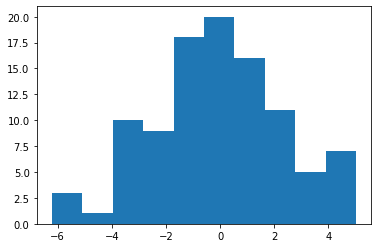

In [18]:
plt.hist(x[:, 0])

In [19]:
dist.compute_metrics(x)

{'square_errors': DeviceArray([[9.2933515e-05],
              [1.5830113e-02],
              [7.0123031e-05],
              [1.6512284e-03]], dtype=float32),
 'ksds': DeviceArray([9.4036850e+01, 8.7121779e-01, 5.5095511e-03, 2.6415207e-06,
              2.5913760e-06], dtype=float32)}